In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import tensorflow.keras as keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import tensorflow as tf
from keras.utils import np_utils
from keras.models import load_model
from keras.datasets import cifar10
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#get the base of the Resnet50 pretrained model
conv_base = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
conv_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
#load data and split into train and test dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

#normalize data
x_train = x_train / 255.0
x_test = x_test / 255.0

y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

print(x_train.shape)
print(x_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [ ]:
from keras.preprocessing.image import ImageDataGenerator

#on the train dataset, generate augmented images
datagen = ImageDataGenerator(
    zoom_range= (0.5,1.5),
    width_shift_range=(-5,5),
    height_shift_range=(-5,5),
    horizontal_flip=True,
    validation_split=0.2)
# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(x_train)

In [ ]:
train_datagen = datagen.flow(x_train, y_train, batch_size=32,subset='training')
test_datagen = datagen.flow(x_train, y_train, batch_size=8, subset='validation')

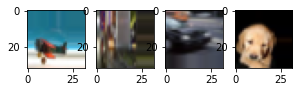

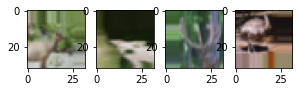

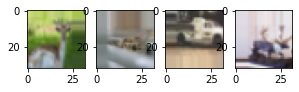

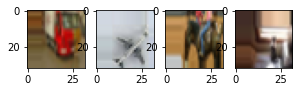

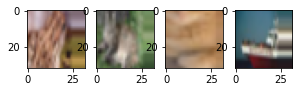

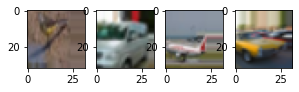

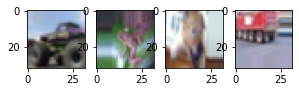

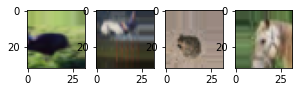

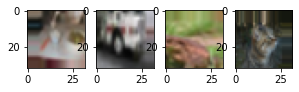

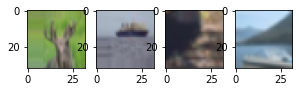

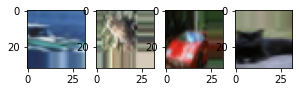

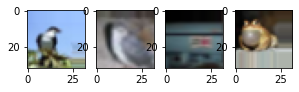

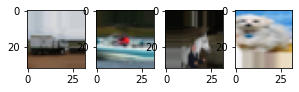

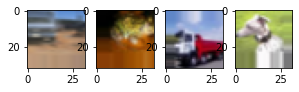

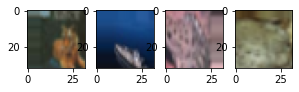

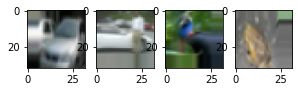

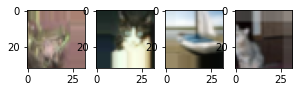

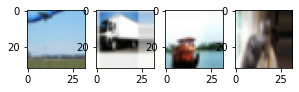

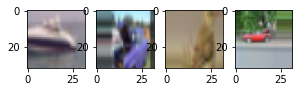

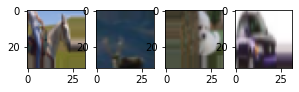

In [ ]:
from matplotlib import pyplot
g = 0

#show augmented images
for X_batch, y_batch in train_datagen:
  for i in range(4):
    pyplot.subplot(255 +1 +i)
    pyplot.imshow(X_batch[i])
  pyplot.show()
  g += 1
  if g == 20:
    break

In [ ]:
#build model
model = models.Sequential()
model.add(layers.UpSampling2D((2,2)))
model.add(layers.UpSampling2D((2,2)))
model.add(layers.UpSampling2D((2,2)))
# model.add(layers.UpSampling2D((2,2)))
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.BatchNormalization())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer=optimizers.RMSprop(learning_rate=0.01), loss='categorical_crossentropy', metrics=['acc'])

In [ ]:
#load saved model to continue training
filepath = "/content/drive/MyDrive/Fund_of_AI_models/resnet50_cifar10.h5"
model = tf.keras.models.load_model(filepath)

In [ ]:
from keras.callbacks import ModelCheckpoint

# define the checkpoint
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max', save_freq = 'epoch')
callbacks_list = [checkpoint]

In [ ]:
#train model
history = model.fit(train_datagen, epochs=10, batch_size=20,  validation_data=test_datagen, callbacks=callbacks_list)

Epoch 1/10
1250/1250 [==============================] - ETA: 0s - loss: 0.0446 - acc: 0.9528
Epoch 1: val_acc did not improve from 0.92970
1250/1250 [==============================] - 326s 253ms/step - loss: 0.0446 - acc: 0.9528 - val_loss: 0.0421 - val_acc: 0.9283
Epoch 2/10
1250/1250 [==============================] - ETA: 0s - loss: 0.0421 - acc: 0.9566
Epoch 2: val_acc did not improve from 0.92970
1250/1250 [==============================] - 315s 252ms/step - loss: 0.0421 - acc: 0.9566 - val_loss: 0.0428 - val_acc: 0.9276
Epoch 3/10
1250/1250 [==============================] - ETA: 0s - loss: 0.0418 - acc: 0.9555
Epoch 3: val_acc did not improve from 0.92970
1250/1250 [==============================] - 316s 252ms/step - loss: 0.0418 - acc: 0.9555 - val_loss: 0.0429 - val_acc: 0.9251
Epoch 4/10
1250/1250 [==============================] - ETA: 0s - loss: 0.0407 - acc: 0.9581
Epoch 4: val_acc did not improve from 0.92970
1250/1250 [==============================] - 316s 253ms/step - 

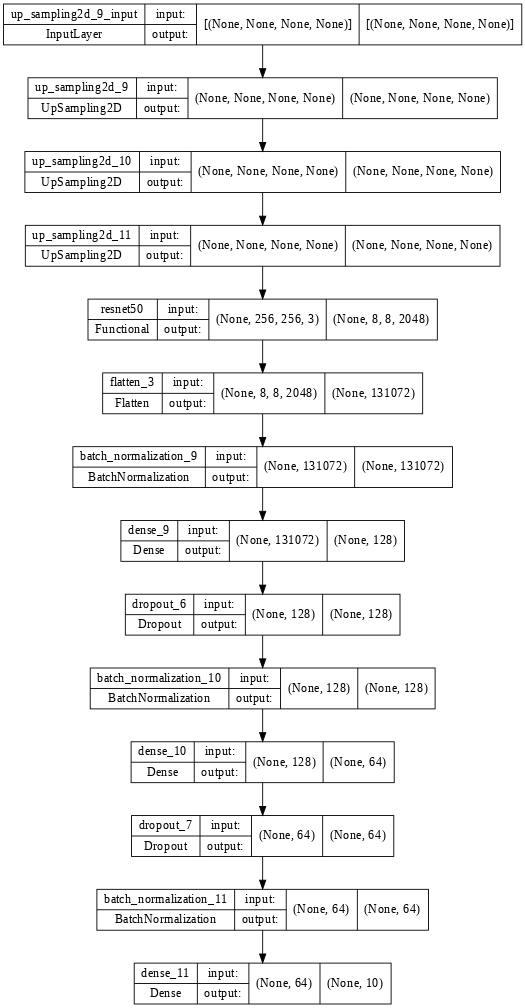

In [ ]:
#model architectures
tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

In [ ]:
model = tf.keras.models.load_model("/content/drive/MyDrive/Fund_of_AI_models/resnet50_cifar10.h5")

In [ ]:
#get model accuracy on raw untouched dataset
model.evaluate(x_test, y_test)

313/313 [==============================] - 22s 67ms/step - loss: 0.0247 - acc: 0.9629


[0.02473491244018078, 0.9628999829292297]

In [ ]:
model.summary()

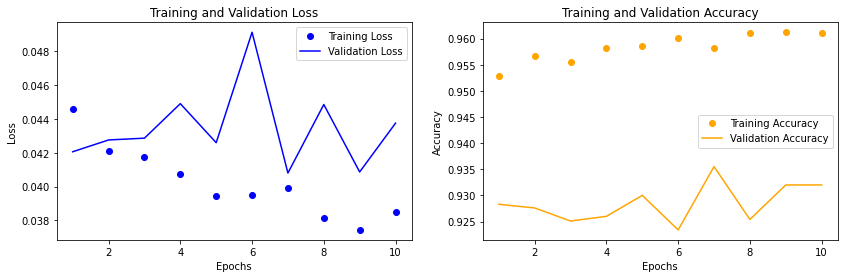

In [ ]:
#create graphs of training and testing accuracy/loss
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(14, 4))

plt.subplot(1,2,1)
plt.plot(epochs, loss_values, 'bo', label='Training Loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

acc = history_dict['acc']
val_acc = history_dict['val_acc']

epochs = range(1, len(loss_values) + 1)

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'bo', label='Training Accuracy', c='orange')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy', c='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [ ]:
# model.save("/content/drive/MyDrive/Fund_of_AI_models/resnet50_cifar10.h5",  save_format="h5")

In [ ]:
#classification report on the untouched test dataset
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix 
predict_x=model.predict(x_test)
# print(predict_x)
predictions=np.argmax(predict_x, axis = 1)
# print(predictions)
print(classification_report(np.argmax(y_test, axis=1),predictions))
print(confusion_matrix(np.argmax(y_test, axis=1),predictions))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1000
           1       0.95      1.00      0.97      1000
           2       0.97      0.95      0.96      1000
           3       0.92      0.93      0.92      1000
           4       0.96      0.97      0.97      1000
           5       0.96      0.91      0.94      1000
           6       0.96      0.99      0.97      1000
           7       0.98      0.98      0.98      1000
           8       0.98      0.97      0.98      1000
           9       0.98      0.96      0.97      1000

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000

[[971   4   4   2   1   0   0   3  12   3]
 [  0 996   0   0   0   0   0   0   0   4]
 [  9   0 947  10  11   7  11   3   2   0]
 [  6   2  11 926  10  25  16   1   1   2]
 [  0   0   5   8 972   2   5   8   0   0]
 [  2   1   6  55   6 914 

In [ ]:
#get model's validation accuracy on transformed test dataset
val_datagen = datagen.flow(x_test, y_test, batch_size=8)
model.evaluate(val_datagen)

1250/1250 [==============================] - 36s 28ms/step - loss: 0.0458 - acc: 0.9248


[0.04575918987393379, 0.9247999787330627]